In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment

# Tune n_estimators & max_depth

In [2]:
# Define parameter grid
n_estimators = list(range(100, 950, 50))
max_depth = list(range(2, 5, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = float('inf')
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    mse_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue

        # Create and fit the model
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            #print("Mean Squared Error: ", mse)
            #print("R-Squared: ", r2)
            mse_scores.append(mse)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'MSE': mse,
                'R2': r2
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average MSE across folds for current parameter combination
    avg_mse = np.mean(mse_scores)
    # Update best parameters if current combination is better
    if avg_mse < best_score:
        best_score = avg_mse
        best_params = (n, d)


100 2
Found cached folds, using those
100 3
Found cached folds, using those
100 4
Found cached folds, using those
150 2
Found cached folds, using those
150 3
Found cached folds, using those
150 4
Found cached folds, using those
200 2
Found cached folds, using those
200 3
Found cached folds, using those
200 4
Found cached folds, using those
250 2
Found cached folds, using those
250 3
Found cached folds, using those
250 4
Found cached folds, using those
300 2
Found cached folds, using those
300 3
Found cached folds, using those
300 4
Found cached folds, using those
350 2
Found cached folds, using those
350 3
Found cached folds, using those
350 4
Found cached folds, using those
400 2
Found cached folds, using those
400 3
Found cached folds, using those
400 4
Found cached folds, using those
450 2
Found cached folds, using those
450 3
Found cached folds, using those
450 4
Found cached folds, using those
500 2
Found cached folds, using those
500 3
Found cached folds, using those
500 4
Found 

In [3]:
with open('tuning.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(model_performance))

In [4]:
# Aggregate MSE values for each (n_estimators, max_depth) pair
mse_aggregate = {}
r2_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in mse_aggregate:
        mse_aggregate[key] = []
        r2_aggregate[key] = []
    mse_aggregate[key].append(entry['MSE'])
    r2_aggregate[key].append(entry['R2'])

# Calculate average MSE & R2 for each pair
average_mse = {k: sum(v)/len(v) for k, v in mse_aggregate.items()}
average_r2 = {k: sum(v)/len(v) for k, v in r2_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_mse.keys()]
max_depth = [k[1] for k in average_mse.keys()]
avg_mse = list(average_mse.values())
avg_r2 = list(average_r2.values())


In [5]:

# sorted_data = sorted(model_performance, key=lambda x: (x["MSE"], -x["R2"]))
# pprint.PrettyPrinter(width=20).pprint(sorted_data)
# sorted(average_mse.items(), key=lambda x:x[1])


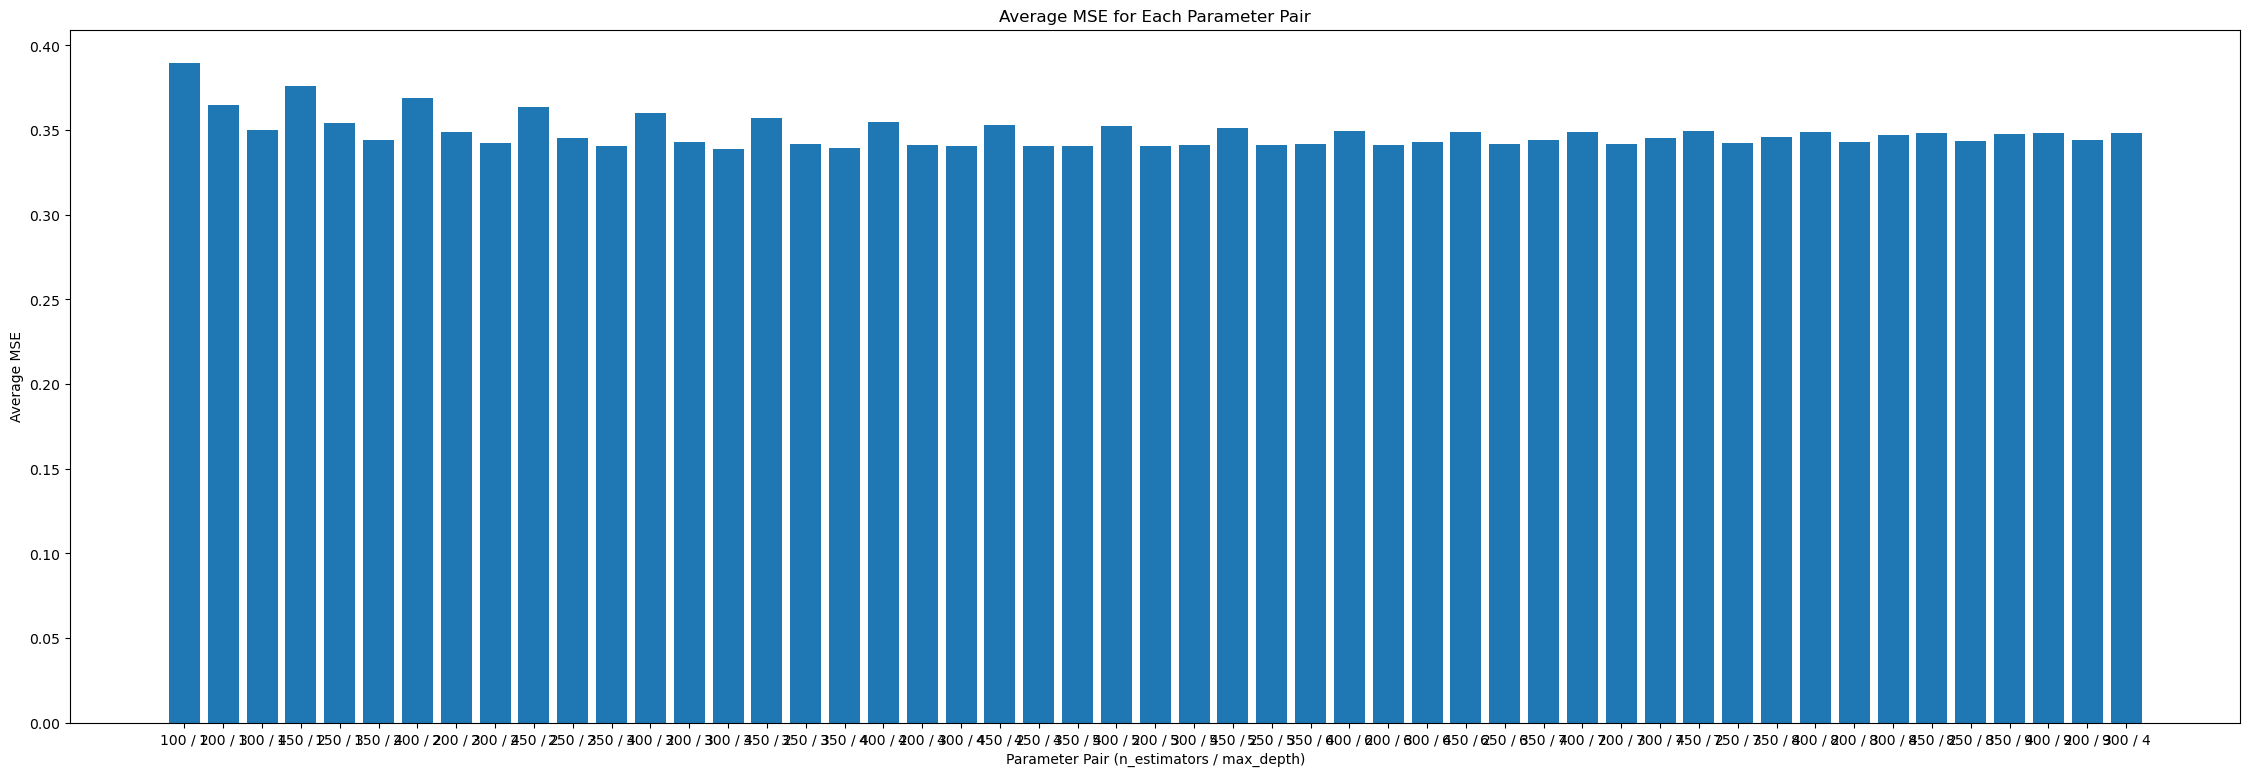

In [6]:
plt.figure(figsize=(28,9))
plt.bar(range(len(avg_mse)), avg_mse, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average MSE')
plt.title('Average MSE for Each Parameter Pair')
plt.savefig('Average MSE for Each Parameter Pair.png')
plt.show()

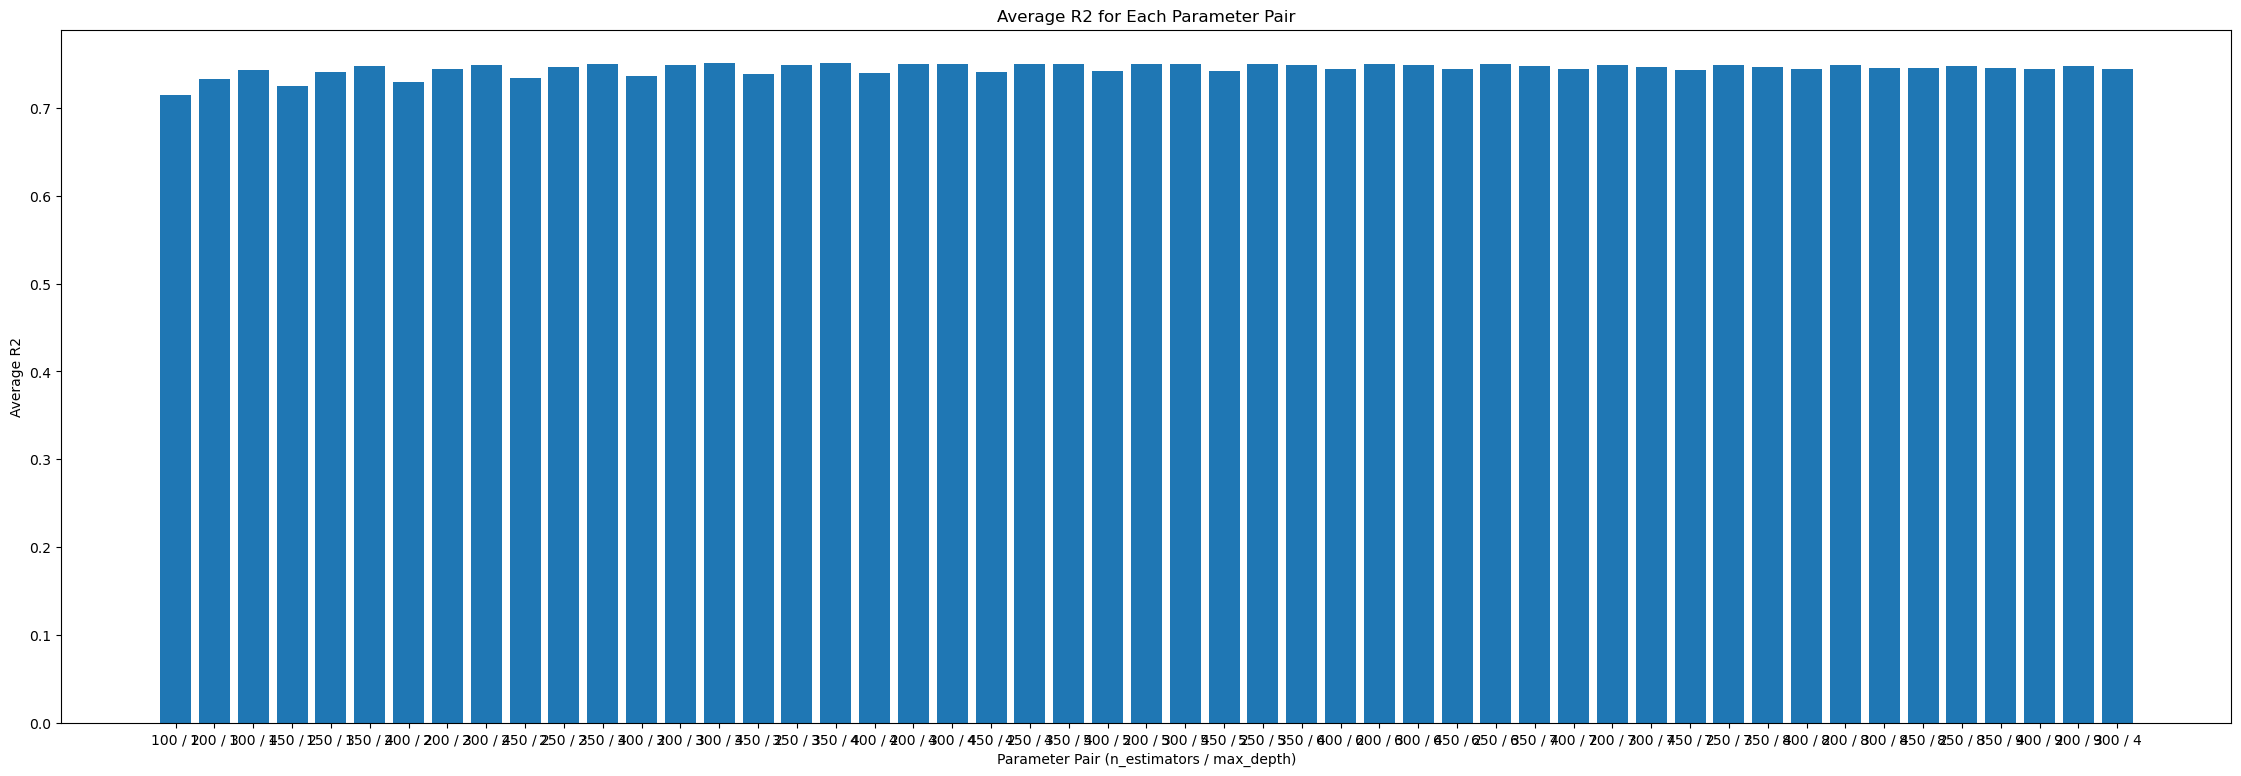

In [7]:
plt.figure(figsize=(28,9))
plt.bar(range(len(avg_r2)), avg_r2, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average R2')
plt.title('Average R2 for Each Parameter Pair')
plt.savefig('Average R2 for Each Parameter Pair.png')
plt.show()

In [8]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with MSE: {best_score}")

Best parameters: n_estimators=300, max_depth=4 with MSE: 0.33874009404870986


In [9]:
from scipy.stats import iqr
mse_values_by_params = {}
for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in mse_values_by_params:
        mse_values_by_params[key] = []
    mse_values_by_params[key].append(entry['MSE'])

# Calculate IQR for MSE values for each pair of hyperparameters
iqr_by_params = {k: iqr(v) for k, v in mse_values_by_params.items()}

In [12]:
print(iqr_by_params)

{(100, 2): 0.023077817030246806, (100, 3): 0.014091242557892514, (100, 4): 0.01294671492537891, (150, 2): 0.021483059292521478, (150, 3): 0.007797242277408967, (150, 4): 0.014776407502260447, (200, 2): 0.021261888042435895, (200, 3): 0.004312488932456726, (200, 4): 0.01711356797914182, (250, 2): 0.023309025198011868, (250, 3): 0.0025159750753662724, (250, 4): 0.01316781054963545, (300, 2): 0.023978329032827483, (300, 3): 0.002849766742685278, (300, 4): 0.012573416055464082, (350, 2): 0.022550893438294473, (350, 3): 0.004407204873214388, (350, 4): 0.012012483912600291, (400, 2): 0.024244399097732683, (400, 3): 0.004530474468510071, (400, 4): 0.011575457123777, (450, 2): 0.021603418047034362, (450, 3): 0.005534053778951664, (450, 4): 0.013362389936403263, (500, 2): 0.019066492993183748, (500, 3): 0.0076140567733326, (500, 4): 0.01325346681420353, (550, 2): 0.017719889353042584, (550, 3): 0.007100314266652863, (550, 4): 0.014713925900129154, (600, 2): 0.019872566348651755, (600, 3): 0.005

# Find important feature

In [10]:

results = []
envGen = get_train_environment(n_splits=15)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)

    r2 = r2_score(y_test, predictions)
    print("Mean Squared Error: ", mse, "R-Squared: ", r2)

    thresholds = np.sort(model.feature_importances_)[::-1]
    # Fit model using each importance as a threshold
    for thresh in thresholds:
        if thresh > 0.001:
            # Select features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_X_train = selection.transform(X_train)

            # Get names of selected features
            #selected_features = X_train_fold.columns[selection.get_support()]

            # Train model
            selection_model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
            selection_model.fit(select_X_train, y_train)

            # Eval model
            select_X_test = selection.transform(X_test)
            predictions = selection_model.predict(select_X_test)
            mse_select = mean_squared_error(y_test, predictions)
            r2_select = r2_score(y_test, predictions)
            adjusted_r2_select = 1 - (((1 - r2_select) * (len(y_train) - 1)) / (len(y_train) - select_X_train.shape[1] - 1))

            # Save results to dictionary
            results_dict = {
                'Fold':fold,
                'Threshold': thresh,
                #'Selected Features': list(selected_features),
                'Number of Features': select_X_train.shape[1],
                'MSE': mse_select,
                'R2': r2_select,
                'Adjusted R2': adjusted_r2_select
            }
            results.append(results_dict)
            print("Thresh=%.7f, n=%d, Mean Squared Error: %.4f, R-Squared: %.4f, Adj-R-Squared: %.4f" % (thresh, select_X_train.shape[1], mse_select, r2_select, adjusted_r2_select))
        else:
            break

Found cached folds, using those
Fold: 0
[0.00090555 0.00336634 0.00067244 ... 0.00748046 0.00122966 0.00474461]
Mean Squared Error:  0.3775665992039367 R-Squared:  0.7118054657010036
Thresh=0.1785492, n=1, Mean Squared Error: 0.9656, R-Squared: 0.2630, Adj-R-Squared: 0.2629
Thresh=0.1100014, n=2, Mean Squared Error: 0.7696, R-Squared: 0.4125, Adj-R-Squared: 0.4124
Thresh=0.0170205, n=3, Mean Squared Error: 0.7323, R-Squared: 0.4411, Adj-R-Squared: 0.4409
Thresh=0.0162005, n=4, Mean Squared Error: 0.6650, R-Squared: 0.4924, Adj-R-Squared: 0.4922
Thresh=0.0119939, n=5, Mean Squared Error: 0.6660, R-Squared: 0.4916, Adj-R-Squared: 0.4913
Thresh=0.0103527, n=6, Mean Squared Error: 0.6671, R-Squared: 0.4908, Adj-R-Squared: 0.4905
Thresh=0.0101732, n=7, Mean Squared Error: 0.6263, R-Squared: 0.5219, Adj-R-Squared: 0.5215
Thresh=0.0090379, n=8, Mean Squared Error: 0.5910, R-Squared: 0.5489, Adj-R-Squared: 0.5485
Thresh=0.0090226, n=9, Mean Squared Error: 0.5707, R-Squared: 0.5644, Adj-R-Squar

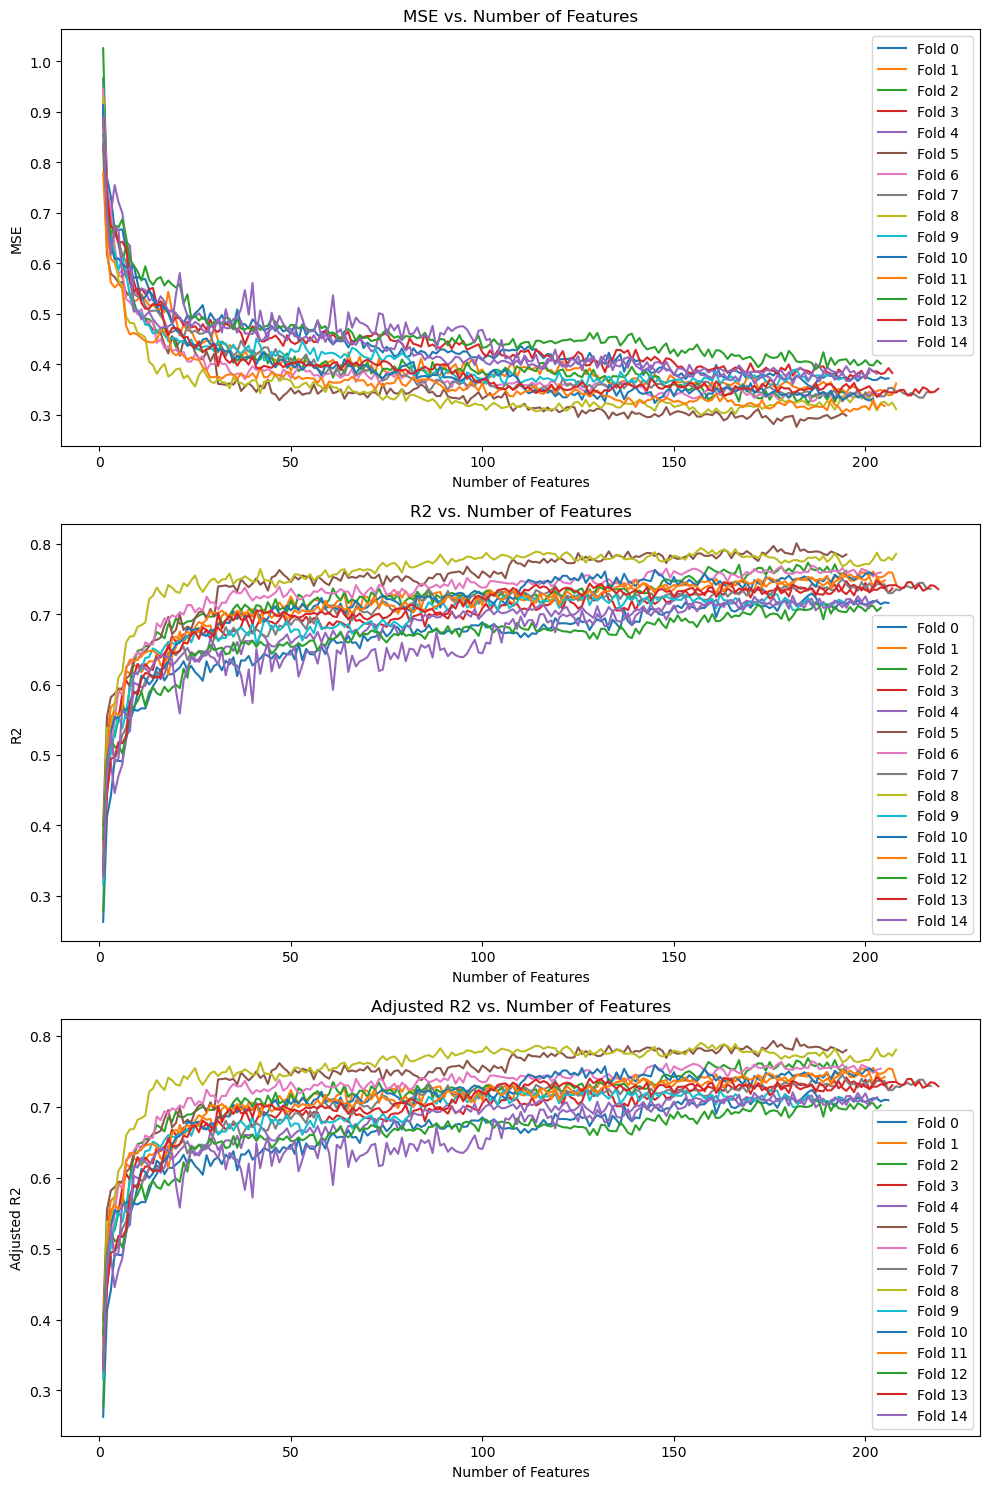

In [11]:
# Preparing data for plotting
data_by_fold = {}
for entry in results:
    fold = entry['Fold']
    if fold not in data_by_fold:
        data_by_fold[fold] = {'Number of Features': [], 'MSE': [], 'R2': [], 'Adjusted R2': []}
    data_by_fold[fold]['Number of Features'].append(entry['Number of Features'])
    data_by_fold[fold]['MSE'].append(entry['MSE'])
    data_by_fold[fold]['R2'].append(entry['R2'])
    data_by_fold[fold]['Adjusted R2'].append(entry['Adjusted R2'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting MSE
for fold, data in data_by_fold.items():
    axes[0].plot(data['Number of Features'], data['MSE'], label=f'Fold {fold}')
axes[0].set_title('MSE vs. Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('MSE')
axes[0].legend()

# Plotting R2
for fold, data in data_by_fold.items():
    axes[1].plot(data['Number of Features'], data['R2'], label=f'Fold {fold}')
axes[1].set_title('R2 vs. Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('R2')
axes[1].legend()

# Plotting Adjusted R2
for fold, data in data_by_fold.items():
    axes[2].plot(data['Number of Features'], data['Adjusted R2'], label=f'Fold {fold}')
axes[2].set_title('Adjusted R2 vs. Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Adjusted R2')
axes[2].legend()

plt.tight_layout()
plt.savefig('XGBoost Feature importance.png')
plt.show()